## Sequential Workflow

In [8]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Optional

### Non-LLM Based Workflow

In [17]:
# define state

class BMIState(TypedDict):
    height: float  # in meters
    weight: float  # in kilograms
    bmi: float  # body mass index
    category: str # BMI category (e.g., "Underweight", "Normal weight", "Overweight", "Obesity")

# define graph
graph = StateGraph(BMIState)



In [18]:
def calculate_bmi(state: BMIState) -> BMIState:
    """Calculate BMI from height and weight."""
    if state['height'] <= 0 or state['weight'] <= 0:
        raise ValueError("Height and weight must be positive values.")
    
    state['bmi'] = round(state['weight'] / (state['height'] ** 2), 2)
    return state

def categorize_bmi(state: BMIState) -> BMIState:
    """Categorize BMI into standard categories."""
    if state['bmi'] < 18.5:
        state['category'] = "Underweight"
    elif 18.5 <= state['bmi'] < 24.9:
        state['category'] = "Normal weight"
    elif 25 <= state['bmi'] < 29.9:
        state['category'] = "Overweight"
    else:
        state['category'] = "Obesity"
    
    return state

In [19]:
# define nodes
graph.add_node("calculate_bmi", calculate_bmi)
graph.add_node("categorize_bmi", categorize_bmi)

# define workflow
graph.add_edge(START, "calculate_bmi")
graph.add_edge("calculate_bmi", "categorize_bmi")
graph.add_edge("categorize_bmi", END)

# compile the graph
workflow = graph.compile()

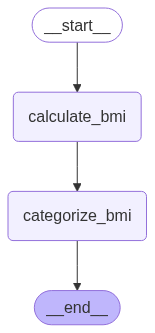

In [20]:
workflow

In [21]:
# execute the workflow
# Example input state
input_state = {    "height": 1.75,  # meters
    "weight": 73.0,  # kilograms  }
}

final_state = workflow.invoke(input_state)

print(final_state)  # Output should include the calculated BMI


{'height': 1.75, 'weight': 73.0, 'bmi': 23.84, 'category': 'Normal weight'}


### LLM Based Workflow


In [42]:
# %pip install langchain-huggingface
# %pip install python-dotenv
# %pip install transformers

In [41]:
# import os
# from langchain_huggingface import HuggingFacePipeline
# from langchain_core.prompts import ChatPromptTemplate
# from langchain_core.output_parsers import StrOutputParser
# from dotenv import load_dotenv

# # Load environment variables
# load_dotenv()
# # Set your Hugging Face API token (uncomment and set your token if not in .env)
# # os.environ["HUGGINGFACEHUB_API_TOKEN"] = "YOUR_HUGGINGFACE_API_TOKEN"
# if "HUGGINGFACEHUB_API_TOKEN" not in os.environ or not os.environ["HUGGINGFACEHUB_API_TOKEN"]:
#     raise EnvironmentError(
#         "HUGGINGFACEHUB_API_TOKEN not set. Please set it in your .env file or directly in the code."
#     )

# # 1. Instantiate the Chat Model (running locally)
# # Make sure you have enough RAM and a compatible GPU for this model.
# llm = HuggingFacePipeline.from_model_id(
#     model_id="meta-llama/Meta-Llama-3-8B-Instruct",
#     task="text-generation",
#     pipeline_kwargs={
#         "max_new_tokens": 250,
#         "top_k": 50,
#         "temperature": 0.1,
#     },
# )

# # 2. Create a Prompt Template
# messages = [
#     ("system", "You are a helpful assistant."),
#     ("user", "{user_input}"),
# ]

# prompt = ChatPromptTemplate.from_messages(messages)

# # 3. Create a Chain
# chain = prompt | llm | StrOutputParser()

# # 4. Invoke the Chain
# user_input = "What is the capital of France and what is it famous for?"
# response = chain.invoke({"user_input": user_input})

# print(response)

In [47]:
# %pip install langchain_openai

In [50]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, Optional
from dotenv import load_dotenv

In [49]:
load_dotenv()

model = ChatOpenAI()

In [51]:
def llm_qa(state: 'QnAState') -> 'QnAState':
    """Use LLM to answer the question."""
    if not state['question']:
        raise ValueError("Question cannot be empty.")

    prompt = f"Answer the following question: {state['question']}"
    
    response = model.invoke(prompt)
    state['answer'] = response.content
    return state

In [52]:
class QnAState(TypedDict):
    question: str
    answer: Optional[str] = None

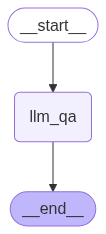

In [53]:
graph = StateGraph(QnAState)

graph.add_node("llm_qa", llm_qa)
graph.add_edge(START, "llm_qa")
graph.add_edge("llm_qa", END)

workflow = graph.compile()

workflow


In [ ]:
init_state = {"question": "What is the capital of France?"}

final_state = workflow.invoke(init_state)

print(final_state)  


{'question': 'What is the capital of France?', 'answer': 'The capital of France is Paris.'}


## Parallel Workflow

### Example 1: Creating a Simple Parallel Workflow 

In [55]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, Optional
from dotenv import load_dotenv

In [68]:
class BatsmanState(TypedDict):
    runs: int
    balls: int
    fours: int
    sixes: int

    sr: float  # strike rate
    bpb: float  # balls per boundary
    boundary_percentage: float  # percentage of runs from boundaries
    summary: str  # summary of performance


In [87]:
def calculate_sr(state: BatsmanState):
    """Calculate strike rate."""
    if state['balls'] == 0:
        raise ValueError("Balls cannot be zero.")
    
    sr = round((state['runs'] / state['balls']) * 100, 2)

    return {'sr': sr}

def calculate_bpb(state: BatsmanState):
    """Calculate balls per boundary."""
    if state['fours'] + state['sixes'] == 0:
        raise ValueError("Fours and sixes cannot be zero.")
    
    bpb = round(state['balls'] / (state['fours'] + state['sixes']), 2)

    return {'bpb':bpb}

def calculate_boundary_percentage(state: BatsmanState):
    """Calculate percentage of runs from boundaries."""
    if state['runs'] == 0:
        raise ValueError("Runs cannot be zero.")
    
    boundary_runs = (state['fours'] * 4) + (state['sixes'] * 6)
    boundary_percentage = round((boundary_runs / state['runs']) * 100, 2)

    return {'boundary_percentage': boundary_percentage}

def summarize_batsman(state: BatsmanState) :
    """Summarize batsman's performance."""
    summary = f"""
        Batsman scored {state['runs']} runs in {state['balls']} balls with 
        {state['fours']} fours and {state['sixes']} sixes. 
        f"Strike Rate: {state['sr']}, Balls per Boundary: {state['bpb']}, 
        f"Boundary Percentage: {state['boundary_percentage']}
    """
    
    return {'summary': summary}
    
    # state['summary'] = summary
    # return state

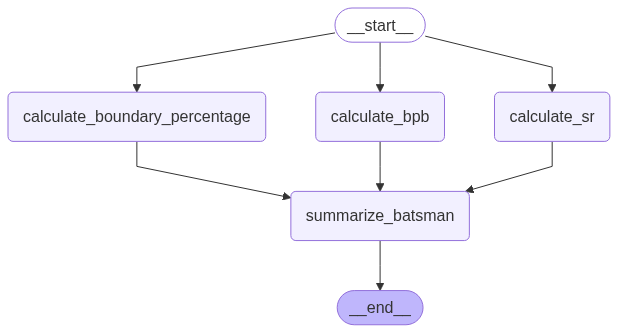

In [88]:
graph = StateGraph(BatsmanState)

graph.add_node("calculate_sr", calculate_sr)
graph.add_node("calculate_bpb", calculate_bpb)
graph.add_node("calculate_boundary_percentage", calculate_boundary_percentage)
graph.add_node("summarize_batsman", summarize_batsman)

graph.add_edge(START, "calculate_sr")
graph.add_edge(START, "calculate_bpb")
graph.add_edge(START, "calculate_boundary_percentage")
graph.add_edge("calculate_sr", "summarize_batsman")
graph.add_edge("calculate_bpb", "summarize_batsman")
graph.add_edge("calculate_boundary_percentage", "summarize_batsman")
graph.add_edge("summarize_batsman", END)

workflow = graph.compile()

workflow


In [89]:
input_state = {
    "runs": 100,
    "balls": 50,
    "fours": 10,
    "sixes": 5,
}

final_state = workflow.invoke(input_state)
print(final_state)  # Output should include the calculated metrics and summary

final_state['summary']  # This will print the summary of the batsman's performance


{'runs': 100, 'balls': 50, 'fours': 10, 'sixes': 5, 'sr': 200.0, 'bpb': 3.33, 'boundary_percentage': 70.0, 'summary': '\n        Batsman scored 100 runs in 50 balls with \n        10 fours and 5 sixes. \n        f"Strike Rate: 200.0, Balls per Boundary: 3.33, \n        f"Boundary Percentage: 70.0\n    '}


'\n        Batsman scored 100 runs in 50 balls with \n        10 fours and 5 sixes. \n        f"Strike Rate: 200.0, Balls per Boundary: 3.33, \n        f"Boundary Percentage: 70.0\n    '

### Example 2: UPSC Essay Evaluation

The UPSC (Union Public Service Commission) conducts a civil services examination that includes an essay paper. The evaluation of the essay is based on the following criteria:
- Clarity of thought (10 points)
- Depth of Analysis (10 points)
- Language (10 points)

Idea is to evaluate the essay based on these criteria.

In [91]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, Optional, List, Annotated
from pydantic import BaseModel, Field
from dotenv import load_dotenv
import operator

In [93]:
load_dotenv()
model = ChatOpenAI(model="gpt-4o-mini")

In [94]:
class FeedbackSchema(BaseModel):
    feedback: str = Field(..., description="Detailed feedback on the essay")
    score: int = Field(description="Score out of 10",  ge=0, le=10)

structured_model =  model.with_structured_output(FeedbackSchema)

In [107]:
class EssayEvaluationState(TypedDict):

    essay: str
    cot_feedback: Optional[str] = None
    doa_feedback: Optional[str] = None
    language_feedback: Optional[str] = None
    overall_feedback: Optional[str] = None
    scores: Annotated[List[float], operator.add]  # List to hold scores for each criterion. We are using Reducer to add scores in parallel process.
    final_score: Optional[float] = None  # Final score after averaging


def evaluate_clarity_of_thought(state: EssayEvaluationState):
    """Evaluate clarity of thought."""
    prompt = f"Evaluate the clarity of thought in the following essay:\n{state['essay']}"
    response = structured_model.invoke(prompt)
    cot_feedback = response.feedback
    score = response.score
    return {
        'cot_feedback': cot_feedback, 'scores': [score]
    }

def evaluate_depth_of_analysis(state: EssayEvaluationState):
    """Evaluate depth of analysis."""
    prompt = f"Evaluate the depth of analysis in the following essay:\n{state['essay']}"
    response = structured_model.invoke(prompt)
    doa_feedback = response.feedback
    score = response.score
    return {
        'doa_feedback': doa_feedback, 'scores': [score]
    }

def evaluate_language(state: EssayEvaluationState):
    """Evaluate language used in the essay."""
    prompt = f"Evaluate the language used in the following essay:\n{state['essay']}"
    response = structured_model.invoke(prompt)
    language_feedback = response.feedback
    score = response.score
    return {
        'language_feedback': language_feedback, 'scores': [score]
    }

def final_evaluation(state: EssayEvaluationState):
    """Combine feedback and calculate final score."""
    prommpt = f"Based on the feedback provided, summarize the overall evaluation of the essay. Clarity of Thought Feedback: {state['cot_feedback']}, Depth of Analysis Feedback: {state['doa_feedback']}, Language Feedback: {state['language_feedback']}"
    response = model.invoke(prommpt)
    overall_feedback = response.content
    # state['overall_feedback'] = overall_feedback
    
    # Calculate final score as the average of individual scores
    if state['scores']:
        final_score = round(sum(state['scores']) / len(state['scores']), 2)
    else:
        final_score = 0.0
    
    return {'overall_feedback': overall_feedback, 'final_score': final_score}

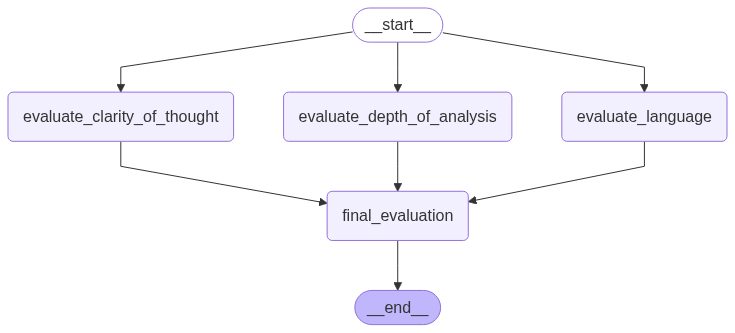

In [108]:
graph = StateGraph(EssayEvaluationState)

graph.add_node("evaluate_clarity_of_thought", evaluate_clarity_of_thought)
graph.add_node("evaluate_depth_of_analysis", evaluate_depth_of_analysis)
graph.add_node("evaluate_language", evaluate_language)
graph.add_node("final_evaluation", final_evaluation)

graph.add_edge(START, "evaluate_clarity_of_thought")
graph.add_edge(START, "evaluate_depth_of_analysis")
graph.add_edge(START, "evaluate_language")
graph.add_edge("evaluate_clarity_of_thought", "final_evaluation")
graph.add_edge("evaluate_depth_of_analysis", "final_evaluation")
graph.add_edge("evaluate_language", "final_evaluation")
graph.add_edge("final_evaluation", END)

workflow = graph.compile()
workflow

In [97]:
essay = """India and AI Time

Now world change very fast because new tech call Artificial Intel… something (AI). India also want become big in this AI thing. If work hard, India can go top. But if no careful, India go back.

India have many good. We have smart student, many engine-ear, and good IT peoples. Big company like TCS, Infosys, Wipro already use AI. Government also do program “AI for All”. It want AI in farm, doctor place, school and transport.

In farm, AI help farmer know when to put seed, when rain come, how stop bug. In health, AI help doctor see sick early. In school, AI help student learn good. Government office use AI to find bad people and work fast.

But problem come also. First is many villager no have phone or internet. So AI not help them. Second, many people lose job because AI and machine do work. Poor people get more bad.

One more big problem is privacy. AI need big big data. Who take care? India still make data rule. If no strong rule, AI do bad.

India must all people together – govern, school, company and normal people. We teach AI and make sure AI not bad. Also talk to other country and learn from them.

If India use AI good way, we become strong, help poor and make better life. But if only rich use AI, and poor no get, then big bad thing happen.

So, in short, AI time in India have many hope and many danger. We must go right road. AI must help all people, not only some. Then India grow big and world say "good job India"."""

In [109]:
init_state = {
    "essay": essay,
}

final_state = workflow.invoke(init_state)
print(final_state)  # Output should include the feedback and scores

{'essay': 'India and AI Time\n\nNow world change very fast because new tech call Artificial Intel… something (AI). India also want become big in this AI thing. If work hard, India can go top. But if no careful, India go back.\n\nIndia have many good. We have smart student, many engine-ear, and good IT peoples. Big company like TCS, Infosys, Wipro already use AI. Government also do program “AI for All”. It want AI in farm, doctor place, school and transport.\n\nIn farm, AI help farmer know when to put seed, when rain come, how stop bug. In health, AI help doctor see sick early. In school, AI help student learn good. Government office use AI to find bad people and work fast.\n\nBut problem come also. First is many villager no have phone or internet. So AI not help them. Second, many people lose job because AI and machine do work. Poor people get more bad.\n\nOne more big problem is privacy. AI need big big data. Who take care? India still make data rule. If no strong rule, AI do bad.\n\n

In [110]:
print(final_state['overall_feedback'])  # This will print the overall feedback on the essay

print(final_state['scores'])  # This will print the final score based on the evaluations

print(final_state['final_score'])  # This will print the final score based on the evaluations

The overall evaluation of the essay indicates that, while it addresses important themes related to the implications of AI in India, it suffers from several notable shortcomings. 

**Clarity of Thought**: The essay's clarity is hindered by grammatical errors and informal language, which detracts from the seriousness of the topic. Though it identifies potential benefits and challenges of AI, the arguments are underdeveloped and lack logical continuity. Ideas presented, such as those regarding the effects of AI on agriculture, healthcare, and education, are not elaborated upon sufficiently, leading to a lack of depth in analysis. Furthermore, the conclusion fails to synthesize key points, merely restating earlier arguments without providing new insights.

**Depth of Analysis**: While the essay provides a basic overview of how AI could impact various sectors, it lacks detailed exploration of key issues. Specific areas for improvement include clearer language and structure, more comprehensi

## Conditional Workflow

### Example 1: Qadratic Equation Workflow

In [111]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, Optional, List, Annotated
from pydantic import BaseModel, Field
from dotenv import load_dotenv
import operator

In [114]:
class QadState(TypedDict):
    a: float
    b: float
    c: float

    equation: str
    discriminant: Optional[float] = None
    result: str

def create_equation(state: QadState):
    """Create the quadratic equation string."""
    if state['a'] == 0:
        raise ValueError("Coefficient 'a' cannot be zero.")
    
    equation = f"{state['a']}x^2 + {state['b']}x + {state['c']} = 0"

    return {'equation': equation}

def calculate_discriminant(state: QadState):
    """Calculate the discriminant of the quadratic equation."""
    discriminant = round((state['b'] ** 2) - (4 * state['a'] * state['c']), 2)

    return {'discriminant': discriminant}

from typing import Literal

def check_discriminant(state: QadState) -> Literal['real_roots', 'repeatable_root', 'complex_roots']:
    """Check the nature of the roots based on the discriminant."""
    if state['discriminant'] > 0:
        return 'real_roots'
    elif state['discriminant'] == 0:
        return 'repeatable_root'
    else:
        return 'complex_roots'

def real_roots(state: QadState):
    """Calculate the real roots of the quadratic equation."""
  
    root1 = round((-state['b'] + state['discriminant'] ** 0.5) / (2 * state['a']), 2)
    root2 = round((-state['b'] - state['discriminant'] ** 0.5) / (2 * state['a']), 2)

    return {'result': f"Real roots are: {root1} and {root2}"}

def repeatable_root(state: QadState):
    """Calculate the repeatable root of the quadratic equation."""
    root = round(-state['b'] / (2 * state['a']), 2)

    return {'result': f"Repeatable root is: {root}"}

def complex_roots(state: QadState):
    """Calculate the complex roots of the quadratic equation."""
    real_part = round(-state['b'] / (2 * state['a']), 2)
    imaginary_part = round((abs(state['discriminant']) ** 0.5) / (2 * state['a']), 2)

    return {'result': f"Complex roots are: {real_part} + {imaginary_part}i and {real_part} - {imaginary_part}i"}

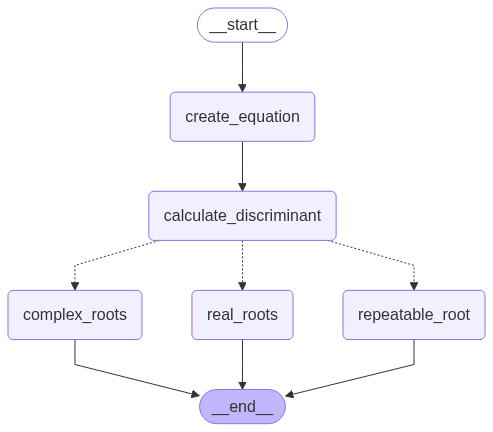

In [115]:
graph = StateGraph(QadState)

graph.add_node("create_equation", create_equation)
graph.add_node("calculate_discriminant", calculate_discriminant)
# graph.add_node("check_discriminant", check_discriminant)
graph.add_node("real_roots", real_roots)
graph.add_node("repeatable_root", repeatable_root)
graph.add_node("complex_roots", complex_roots)

graph.add_edge(START, "create_equation")
graph.add_edge("create_equation", "calculate_discriminant")
graph.add_conditional_edges("calculate_discriminant", check_discriminant)
graph.add_edge("real_roots", END)
graph.add_edge("repeatable_root", END)
graph.add_edge("complex_roots", END)

workflow = graph.compile()

workflow



In [116]:
init_state = {
    "a": 1,
    "b": -3,
    "c": 2,
}

final_state = workflow.invoke(init_state)
print(final_state)  # Output should include the equation, discriminant, and roots

{'a': 1, 'b': -3, 'c': 2, 'equation': '1x^2 + -3x + 2 = 0', 'discriminant': 1, 'result': 'Real roots are: 2.0 and 1.0'}


In [117]:
init_state = {
    "a": 1,
    "b": -1,
    "c": 2,
}

final_state = workflow.invoke(init_state)
print(final_state)  # Output should include the equation, discriminant, and roots

{'a': 1, 'b': -1, 'c': 2, 'equation': '1x^2 + -1x + 2 = 0', 'discriminant': -7, 'result': 'Complex roots are: 0.5 + 1.32i and 0.5 - 1.32i'}


### Example 2: Customer Support Workflow


In [2]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, Literal
from dotenv import load_dotenv
from pydantic import BaseModel, Field

In [3]:
load_dotenv()
model = ChatOpenAI(model="gpt-4o-mini")


In [4]:
class SentimentSchema(BaseModel):

    sentiment: Literal['positive', 'negative'] = Field(..., description="Sentiment of the review")

class DiagnosisSchema(BaseModel):

    issue_type: Literal['hardware', 'software', 'UX', 'performance', 'other'] = Field(..., description="Type of issue mentioned in the review")
    tone: Literal['angry', 'frustrated', 'neutral', 'satisfied'] = Field(..., description="Tone of the review")
    urgency: Literal['low', 'medium', 'high'] = Field(..., description="Urgency of the issue based on the review")

sentiment_model = model.with_structured_output(SentimentSchema)
diagnosis_model = model.with_structured_output(DiagnosisSchema)

In [11]:
class ReviewAnalysisState(TypedDict):
    review: str
    sentiment: Literal['positive', 'negative']
    diagnosis: dict
    response: str

def analyze_sentiment(state: ReviewAnalysisState):
    """Analyze the sentiment of the review."""
    if not state['review']:
        raise ValueError("Review cannot be empty.")
    
    prompt = f"Analyze the sentiment of the following review: {state['review']}"
    
    response = sentiment_model.invoke(prompt)
    sentiment = response.sentiment

    return {'sentiment': sentiment}

def check_sentiment(state: ReviewAnalysisState) -> Literal['positive_response', 'run_diagnosis']:
    """Check the sentiment of the review."""
    if state['sentiment'] == 'positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'
    

def positive_response(state: ReviewAnalysisState):
    """Generate a positive response for the review."""
    prompt = f"Generate a positive response for the following review: {state['review']}"
    
    response = model.invoke(prompt)
    response_content = response.content

    return {'response': response_content}

def run_diagnosis(state: ReviewAnalysisState):
    """Run diagnosis on the review to identify issues."""
    prompt = f"Diagnose the following negative review and identify the issue type, tone, and urgency: {state['review']}"
    
    response = diagnosis_model.invoke(prompt)
    issue_type = response.issue_type
    tone = response.tone
    urgency = response.urgency

    return {'diagnosis': {'issue_type': issue_type, 'tone': tone, 'urgency': urgency}}

def generate_diagnosis_response(state: ReviewAnalysisState):
    """Generate a response based on the diagnosis."""
    
    diagnosis = state['diagnosis']
    if not diagnosis:
        raise ValueError("Diagnosis cannot be empty.")
    if not all(key in diagnosis for key in ['issue_type', 'tone', 'urgency']):
        raise ValueError("Diagnosis must contain issue_type, tone, and urgency.")
    
    prompt = f"""You are a support assistant.
The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
Write an empathetic, helpful resolution message.
"""
    response = model.invoke(prompt)
    response_content = response.content

    return {'response': response_content}



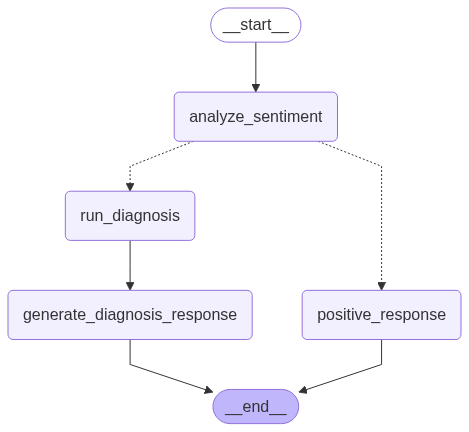

In [12]:
graph = StateGraph(ReviewAnalysisState)

graph.add_node("analyze_sentiment", analyze_sentiment)
graph.add_node("positive_response", positive_response)
graph.add_node("run_diagnosis", run_diagnosis)
graph.add_node("generate_diagnosis_response", generate_diagnosis_response)

graph.add_edge(START, "analyze_sentiment")
graph.add_conditional_edges("analyze_sentiment", check_sentiment)
graph.add_edge("positive_response", END)
graph.add_edge("run_diagnosis", "generate_diagnosis_response")
graph.add_edge("generate_diagnosis_response", END)

workflow = graph.compile()

workflow

In [13]:
intial_state={
    'review': "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}
final_state = workflow.invoke(intial_state)

In [14]:
final_state['response']  # This will print the response generated based on the review analysis

"Subject: We're Here to Help You Resolve Your Software Issue\n\nHi [User's Name],\n\nI genuinely understand how frustrating it can be to encounter software issues, especially when you’re trying to get things done. Thank you for your patience, and I’m here to support you.\n\nTo help you resolve this as quickly as possible, could you please provide me with some additional details? Specifically, it would be helpful to know:\n\n1. A brief description of the issue you're facing.\n2. Any error messages you might have received.\n3. The steps you took before the problem occurred.\n\nOnce I have this information, I’ll do my best to assist you and find a solution right away. Your urgency is noted, and I want to ensure we address this issue promptly.\n\nThank you for your understanding, and I look forward to hearing from you soon.\n\nBest regards,\n\n[Your Name]  \n[Your Position]  \n[Your Contact Information]"

In [15]:
final_state['diagnosis']

{'issue_type': 'software', 'tone': 'frustrated', 'urgency': 'high'}